In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [4]:
df = pd.read_csv("airline-passengers.csv")

In [6]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [8]:
df.shape

(144, 2)

In [7]:
timeseries = df[['Passengers']].values.astype("float32")

In [9]:
#train-test split
train_size = int(len(timeseries)*0.67)
test_size = len(timeseries) - train_size

In [10]:
train_size

96

In [11]:
test_size

48

In [12]:
train, test = timeseries[:train_size],timeseries[train_size:]

In [17]:
def create_dataset(dataset, lookback):
  """Transform the time series into X and y"""
  X,y = [],[]
  for i in range(len(dataset)- lookback):
    features = dataset[i:i+lookback]
    target = dataset[i+1:i+lookback+1]
    X.append(features)
    y.append(target)
  return torch.tensor(X), torch.tensor(y)

In [18]:
lookback = 4
X_train, y_train = create_dataset(train, lookback = lookback)

<ipython-input-17-08d811c052f7>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X), torch.tensor(y)


In [26]:
X_test, y_test = create_dataset(test, lookback = lookback)

In [ ]:
X_train

In [22]:
class AirModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(input_size = 1, hidden_size = 50, num_layers = 1,batch_first = True)
    self.linear = nn.Linear(50,1)

  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.linear(x)
    return x

In [ ]:
1 2 3 4
  2 3 4 5

In [25]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),batch_size = 8)

In [27]:
n_epochs = 2000
for epoch in range(n_epochs):
  model.train()
  for X_batch, y_batch in loader:
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  #Validation
  if epoch%100!=0:
    continue
  model.eval()
  with torch.no_grad():
    y_pred = model(X_train)
    train_rmse = np.sqrt(loss_fn(y_pred,y_train))
    y_pred = model(X_test)
    test_rmse = np.sqrt(loss_fn(y_pred,y_test))
    print("Epoch %d: train RMSE %.4F, test RMSE %.4f"%(epoch,train_rmse,test_rmse))

Epoch 0: train RMSE 226.0103, test RMSE 425.2243
Epoch 100: train RMSE 180.7749, test RMSE 377.8535
Epoch 200: train RMSE 145.5993, test RMSE 339.5892
Epoch 300: train RMSE 117.0703, test RMSE 306.3380
Epoch 400: train RMSE 95.7267, test RMSE 277.9428
Epoch 500: train RMSE 79.4807, test RMSE 253.6747
Epoch 600: train RMSE 65.0960, test RMSE 230.9108
Epoch 700: train RMSE 55.0345, test RMSE 210.9858
Epoch 800: train RMSE 47.2754, test RMSE 193.3740
Epoch 900: train RMSE 41.1172, test RMSE 177.5933
Epoch 1000: train RMSE 36.0462, test RMSE 162.8163
Epoch 1100: train RMSE 32.0814, test RMSE 149.5799
Epoch 1200: train RMSE 29.0800, test RMSE 137.8024
Epoch 1300: train RMSE 26.9053, test RMSE 127.4992
Epoch 1400: train RMSE 25.3204, test RMSE 118.5506
Epoch 1500: train RMSE 23.9903, test RMSE 110.9566
Epoch 1600: train RMSE 22.9155, test RMSE 104.3999
Epoch 1700: train RMSE 22.1389, test RMSE 98.5375
Epoch 1800: train RMSE 21.5236, test RMSE 94.1848
Epoch 1900: train RMSE 21.0419, test RMSE

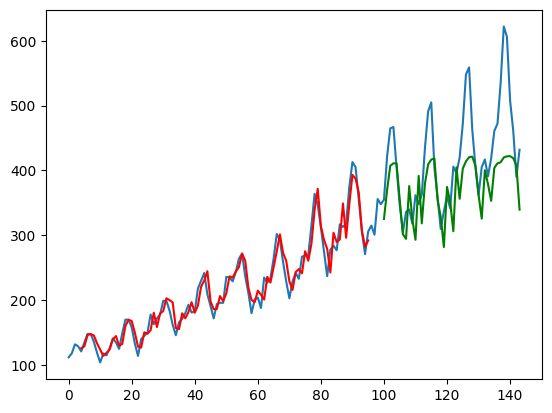

In [29]:
with torch.no_grad():
  #shift the predictions for plotting
  train_plot = np.ones_like(timeseries) * np.nan
  y_pred = model(X_train)
  y_pred = y_pred[:,-1,:]
  train_plot[lookback:train_size] = model(X_train)[:,-1,:]
  #Shift Test Predictions
  test_plot = np.ones_like(timeseries)*np.nan
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:,-1,:]
plt.plot(timeseries)
plt.plot(train_plot,c='r')
plt.plot(test_plot,c = 'g')
plt.show()